In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from torch.nn import Module, Sequential
from torch.nn import Linear, ReLU, Sigmoid, LeakyReLU
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge

In [2]:
# Load and preprocess the data
file_path_train="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Train.csv"
file_path_test="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Test.csv"
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')
df_train['Volume'] = df_train['Volume'].str.replace(',', '').astype(int)
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(int)
X_train = df_train[['Open', 'High', 'Low', 'Close', 'Volume']].values
X_test = df_test[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_train = df_train['Close'].values.reshape(-1, 1)
y_test = df_test['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# Train individual regression models
linear_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
poly_reg = PolynomialFeatures(degree=2)
X_train_poly = poly_reg.fit_transform(X_train_scaled)
X_test_poly = poly_reg.transform(X_test_scaled)
bayesian_reg = BayesianRidge()

linear_reg.fit(X_train_scaled, y_train)
ridge_reg.fit(X_train_scaled, y_train)
lasso_reg.fit(X_train_scaled, y_train)
bayesian_reg.fit(X_train_scaled, y_train)

/Users/ecappiell/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge()

In [4]:
# Get predictions from each model
linear_pred = linear_reg.predict(X_train_scaled)
ridge_pred = ridge_reg.predict(X_train_scaled)
lasso_pred = lasso_reg.predict(X_train_scaled)
bayesian_pred = bayesian_reg.predict(X_train_scaled)

In [5]:
# Concatenate predictions with original features
X_train_ensemble = np.concatenate((X_train_scaled, 
                                    linear_pred.reshape(-1, 1), 
                                    ridge_pred.reshape(-1, 1), 
                                    lasso_pred.reshape(-1, 1), 
                                    bayesian_pred.reshape(-1, 1)), 
                                    axis=1)

In [6]:
# Repeat for test data
linear_pred_test = linear_reg.predict(X_test_scaled)
ridge_pred_test = ridge_reg.predict(X_test_scaled)
lasso_pred_test = lasso_reg.predict(X_test_scaled)
bayesian_pred_test = bayesian_reg.predict(X_test_scaled)

X_test_ensemble = np.concatenate((X_test_scaled, 
                                   linear_pred_test.reshape(-1, 1), 
                                   ridge_pred_test.reshape(-1, 1), 
                                   lasso_pred_test.reshape(-1, 1), 
                                   bayesian_pred_test.reshape(-1, 1)), 
                                   axis=1)

In [7]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_ensemble, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_ensemble, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# Define neural network model
class EnsembleNN(Module):
    def __init__(self, input_size):
        super(EnsembleNN, self).__init__()
        self.fc1 = Linear(input_size, 64)
        self.relu = ReLU()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [9]:
# Initialize model, loss function, and optimizer
model = EnsembleNN(input_size=X_train_ensemble.shape[1])
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [10]:
# Train the model
epochs = 100
batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [11]:
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1732
Epoch [20/100], Loss: 0.4636
Epoch [30/100], Loss: 0.1401
Epoch [40/100], Loss: 0.1365
Epoch [50/100], Loss: 0.0599
Epoch [60/100], Loss: 0.0668
Epoch [70/100], Loss: 0.0820
Epoch [80/100], Loss: 0.0677
Epoch [90/100], Loss: 0.0409
Epoch [100/100], Loss: 0.0099


In [12]:
# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0042


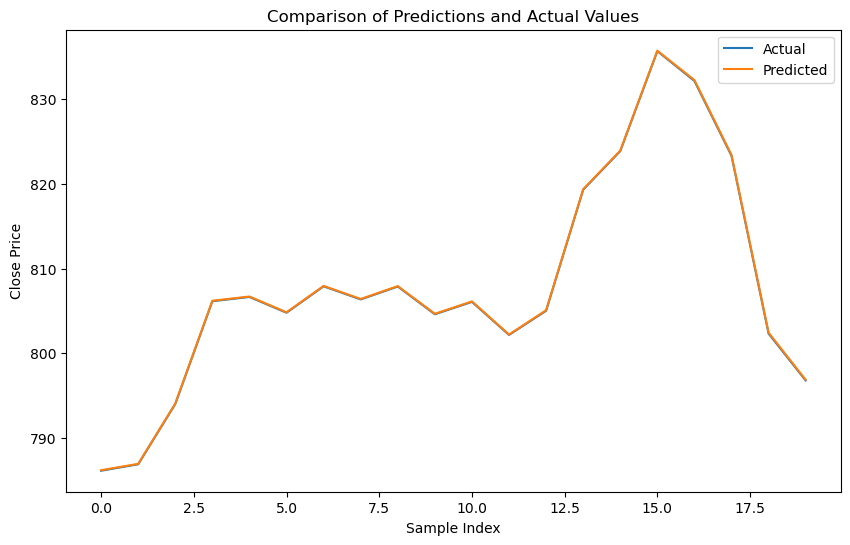

In [14]:
# Convert predictions and actual values to numpy arrays
y_pred_numpy = y_pred.numpy()
y_test_numpy = y_test_tensor.numpy()

# Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_numpy, label='Actual')
plt.plot(y_pred_numpy, label='Predicted')
plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
